# Sales Forecasting

This exploration of forecasting methods is in connection with a group project as part of my Master's degree. I have documented the methods applied to forecast sales from a specific dataset derived from a measure in Power BI. This notebook also includes detailed explanation of the different metrics used to evaluate the forecasts.

<b>Goal:</b> The goal of this project is to apply various methods to forecast the sales from a dataset, provided by Adatis as part of my Master's course in Big Data in Business and Finance.

<b> Models covered in the notebook include: </b> <br>
1. Seasonal Naive Model
2. Linear Regression Model

### Import the required libraries

In [3]:
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

### Load Dataset

The dataset contanins historical sales records from the year 2013 through 2016. 

In [4]:
df = pd.read_csv('data.csv')
df

,Count of OrderID,Date,Week Day Number,Year Quarter Number
0,313,2013-01-01 00:00:00,3,201301
1,382,2013-01-02 00:00:00,4,201301
2,417,2013-01-03 00:00:00,5,201301
3,239,2013-01-04 00:00:00,6,201301
4,250,2013-01-05 00:00:00,7,201301
...,...,...,...,...
985,753,2016-02-24 00:00:00,4,201601
986,412,2016-02-25 00:00:00,5,201601
987,746,2016-02-26 00:00:00,6,201601
988,139,2016-02-27 00:00:00,7,201601


### Missing Values Imputation
There are no missing values in the dataset.

In [5]:
df.isnull().sum()

Count of OrderID       0
Date                   0
Week Day Number        0
Year Quarter Number    0
dtype: int64

### Data Preprocessing
The dataset is split into train and test sets, where the train set contains sales record from January 2013 to November 2015 and the test set (validation set) contains sales records of the subsequent three months (December 2015, January 2016 and February 2016).

Some new features are created from the date field, for the purpose of exploratory data analysis and causal modelling.

In [6]:
# Step 1: Convert Date to DateTime
df['Date'] = pd.to_datetime(df['Date'])

# Step 2: Extract Date Features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Quarter'] = df['Date'].dt.to_period("Q")

# Split the series for forecasting
temp_df = df.set_index('Date')  # Assuming 'Date' is the correct column name
train_df = temp_df.loc[:'2015-11-17'].reset_index(drop=False)
test_df = temp_df.loc['2015-11-18':].reset_index(drop=False)
train_df.head(10)

,Date,Count of OrderID,Week Day Number,Year Quarter Number,Year,Month,Day,Quarter
0,2013-01-01,313,3,201301,2013,1,1,2013Q1
1,2013-01-02,382,4,201301,2013,1,2,2013Q1
2,2013-01-03,417,5,201301,2013,1,3,2013Q1
3,2013-01-04,239,6,201301,2013,1,4,2013Q1
4,2013-01-05,250,7,201301,2013,1,5,2013Q1
5,2013-01-07,654,2,201301,2013,1,7,2013Q1
6,2013-01-08,235,3,201301,2013,1,8,2013Q1
7,2013-01-09,395,4,201301,2013,1,9,2013Q1
8,2013-01-10,507,5,201301,2013,1,10,2013Q1
9,2013-01-11,533,6,201301,2013,1,11,2013Q1


In [7]:
test_df.head(10)

,Date,Count of OrderID,Week Day Number,Year Quarter Number,Year,Month,Day,Quarter
0,2015-11-18,601,4,201504,2015,11,18,2015Q4
1,2015-11-19,529,5,201504,2015,11,19,2015Q4
2,2015-11-20,683,6,201504,2015,11,20,2015Q4
3,2015-11-21,211,7,201504,2015,11,21,2015Q4
4,2015-11-23,709,2,201504,2015,11,23,2015Q4
5,2015-11-24,800,3,201504,2015,11,24,2015Q4
6,2015-11-25,437,4,201504,2015,11,25,2015Q4
7,2015-11-26,291,5,201504,2015,11,26,2015Q4
8,2015-11-27,360,6,201504,2015,11,27,2015Q4
9,2015-11-28,156,7,201504,2015,11,28,2015Q4


### Data Exploration
The plots below try to capture the trend and distribution of sales through weeks, months and years.

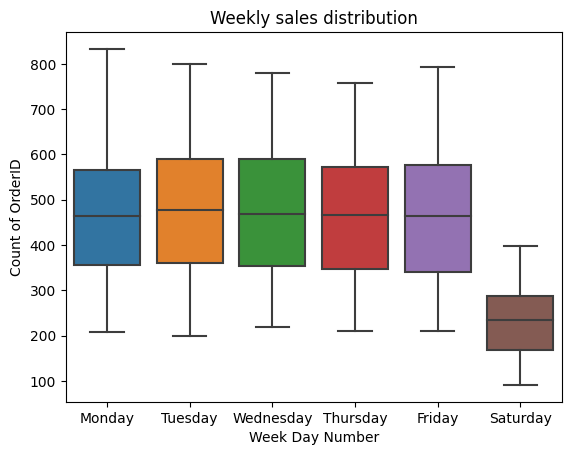

In [8]:
# Define the mapping of Week Day Number to corresponding day names
day_names = {
    2: 'Monday',
    3: 'Tuesday',
    4: 'Wednesday',
    5: 'Thursday',
    6: 'Friday',
    7: 'Saturday'
}

# Create the boxplot with the specified order of weekdays on the x-axis
plot = sns.boxplot(x='Week Day Number', y='Count of OrderID', data=df)

# Set the x-axis tick labels to the corresponding day names
plot.set_xticklabels([day_names[num] for num in range(2, 8)])

# Set the title of the plot
plot.set(title='Weekly sales distribution')

# Show the plot
plt.show()


<b>Comments:</b>  The average number of orders is roughly the same throughout the workweek, with its maximum being on Tuesday, and takes a sharp fall on Saturday. There is no data fow sales made on Sunday.

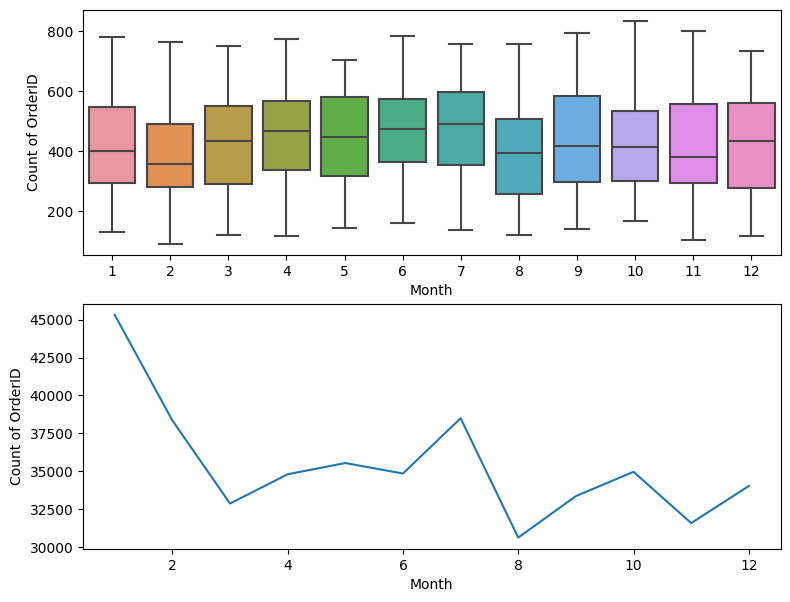

In [9]:
monthly_agg = df.groupby('Month')['Count of OrderID'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='Month', y='Count of OrderID', data=df, ax=axs[0])
_ = sn.lineplot(x='Month', y='Count of OrderID', data=monthly_agg, ax=axs[1])

<b>Comments:</b>  The number of sales ascends at the start of December, peaks in January and then sharply decends through February and March. It then ascends for a second peak in June and reaches its lowest point in August. It rises again around October and drops again right before the rise in November.

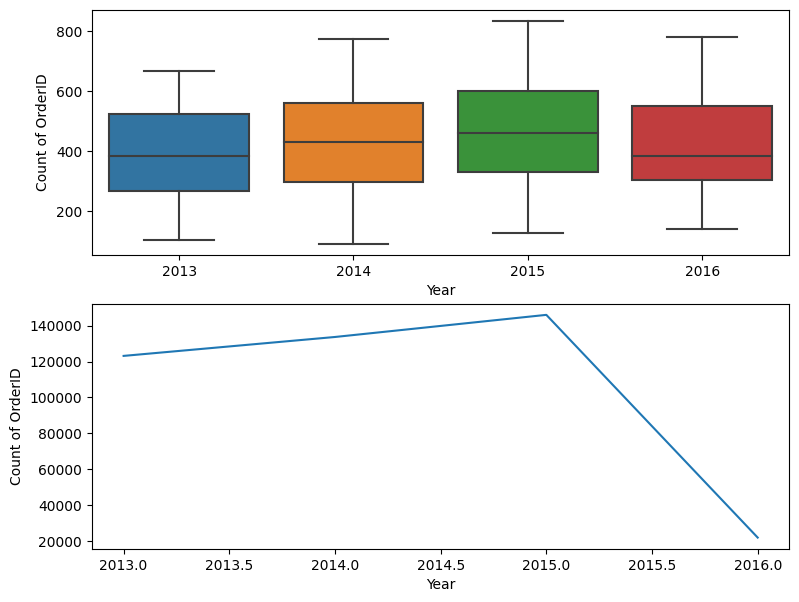

In [12]:
yearly_agg = df.groupby('Year')['Count of OrderID'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='Year', y='Count of OrderID', data=df, ax=axs[0])
_ = sn.lineplot(x='Year', y='Count of OrderID', data=yearly_agg, ax=axs[1])

<b>Comments:</b>  From the number of sales vs. year plot, we can infer an increasing trend over from 2013 to 2015, and a fall in 2016 just below 2013 levels. A clear trend is captured by the lineplot above. 

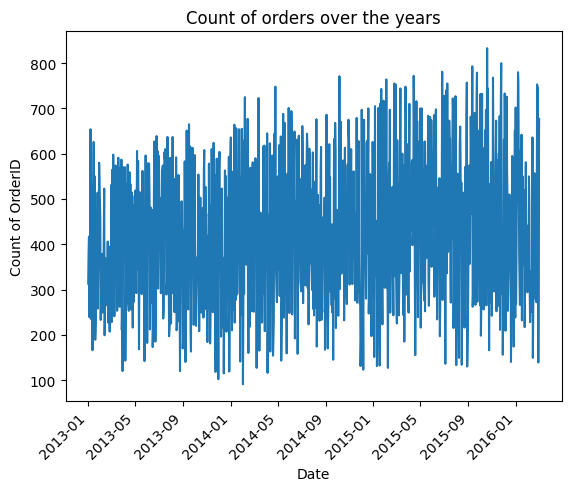

In [13]:
plot = sn.lineplot(x='Date', y='Count of OrderID', data=df)
_ = plot.set(title='Count of orders over the years')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.show()

<b>Comments:</b> There is a seasonal pattern in the number of orders. As also infered in the plot for order count vs. month above, we can see an increase in the sales in the end of each year, peaking in January, and then a gradual decrease till December with a small peak in June. This pattern is repeated each year, 2013 onwards.

### Quantitative Methods to Forecast Product Sales

It can be fairly concluded from the data exploratory plots above that there is seasonality present in the product sales data, along with a greneral increase in the number of sales over the years. Therefore, in order to forecast the number of sales for the last three months of 2015, we will keep in mind the linear trend and seasonality present in the product sales. <br>
There are multiple ways to approach the forecasting problem, we can either build traditional time series models, or use causal models, such as linear regression. We will look at both these methods and try to evaluate our forecasts using the validation set.

### 1. Baseline Model: Seasonal Naive

Before we get to the more advanced time-series forecasting methods, let's take a look at a basic method - Seasonal Naive. It can serve as a quick calculation to get a baseline until something better can come along. Or, perhaps there is very little variance in the data, then this method can be good enough.

<b> What is Seasonal Naive? </b>

It is a naive method that takes the seasonal patterns into account by looking at what happened same time last year. For example, if we want to predict the sales during December 2015, the seasonal naive method will assume the same number of sales for December 2017 as was in December 2014. Fortunately, we have at least one-year of sales data, this method might make no sense otherwise. <br>

In the code below, one year is subtracted from the dates in the test data, and one day is added to the resulting difference, after which they are looked up in the training data to return the sales from those respective dates. So keeping the seasonality in mind, we now have our naive forecasts based on the number of sales from a year ago.

In [159]:
# Fill missing dates in the training data
train_df_filled = train_df.set_index('Date').resample('D').asfreq().ffill().reset_index()

# Subtract 1 year from test data and add 1 day
dates = (test_df['Date'] - pd.DateOffset(years=1) + pd.Timedelta(days=1))

# Filter train_df to include only the dates corresponding to test_df one year earlier
train_df_filtered = train_df_filled[train_df_filled['Date'].dt.date.isin(dates.dt.date)]

# Extract the 'Count of OrderID' for the filtered dates
seasonal_naive_sales = train_df_filtered['Count of OrderID']

# Make a copy of the test_df and make naive predictions for the last 3 months of 2017
sn_pred_df = test_df.copy().drop('Count of OrderID', axis=1)
sn_pred_df = sn_pred_df.reset_index(drop=True)  # Reset the index
sn_pred_df['seasonal_naive_sales'] = seasonal_naive_sales.reset_index(drop=True)
sn_pred_df.head()


,Date,Week Day Number,Year Quarter Number,Year,Month,Day,Quarter,seasonal_naive_sales
0,2015-11-18,4,201504,2015,11,18,2015Q4,679.0
1,2015-11-19,5,201504,2015,11,19,2015Q4,271.0
2,2015-11-20,6,201504,2015,11,20,2015Q4,553.0
3,2015-11-21,7,201504,2015,11,21,2015Q4,293.0
4,2015-11-23,2,201504,2015,11,23,2015Q4,628.0


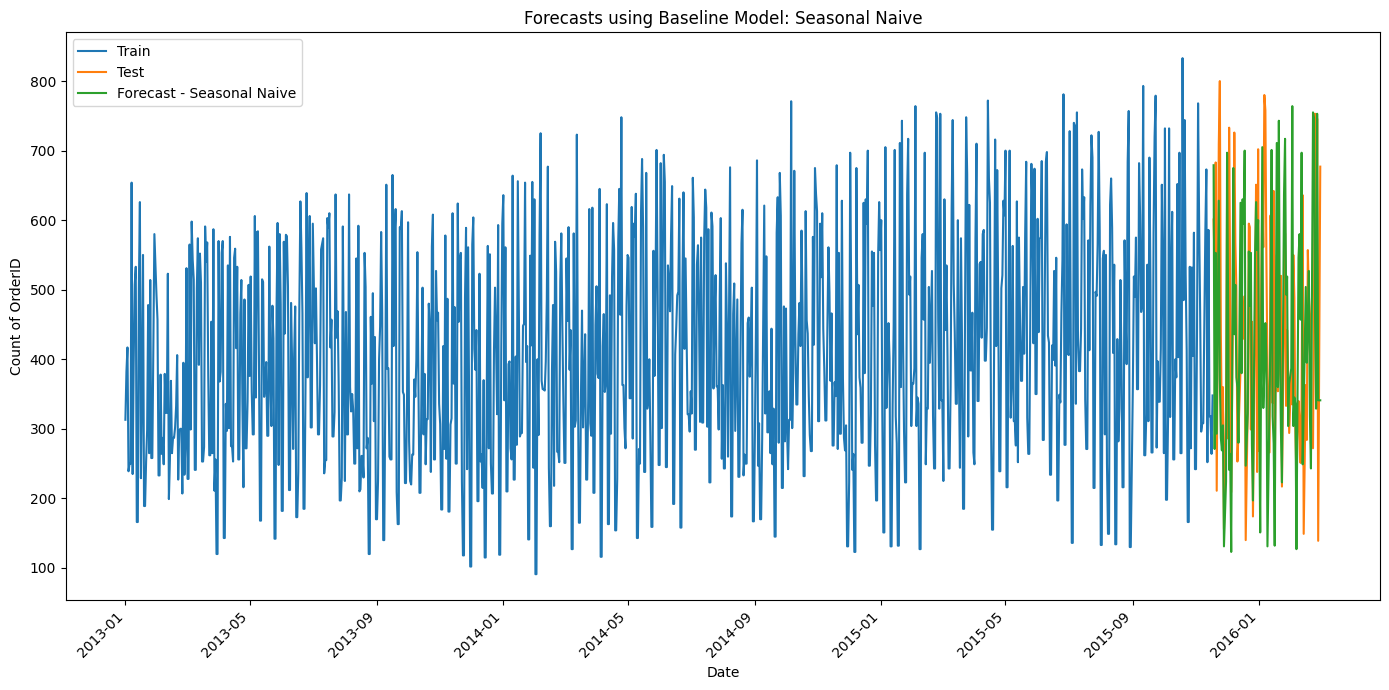

In [160]:
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(train_df_filled['Date'], train_df_filled['Count of OrderID'], label='Train')

# Plot test data
plt.plot(test_df['Date'], test_df['Count of OrderID'], label='Test')

# Plot forecast using seasonal naive model
plt.plot(sn_pred_df['Date'], sn_pred_df['seasonal_naive_sales'], label='Forecast - Seasonal Naive')

plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Count of OrderID')
plt.title('Forecasts using Baseline Model: Seasonal Naive')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()


<b> Comments: </b> We will formally quantify the performance using forecast accuracy metrics.

<b> Evaluating the Forecasts </b>

There are number of widely accepted forecasting metrics, and the most common metric is <b>forecast error</b>. The error can simply be calculated by finding the diffrence between the actual sales value and the forecasted sales value. For example, if 10 items are sold on a day, and you predicted 14 items to be sold, you have an error of -4.

In order to evaluate the overall forecast, we will look at metrics like <b>mean absolute error</b> (MAE), <b>root mean squared error</b> (RMSE) and a percentage error metric - <b>mean absolute percentage error</b> (MAPE).

+ <b>MAE:</b> It is the absolute value of the error, summed for each observed day, and divided by the total number of observed days.

+ <b>RMSE:</b> It is similar to MAE, however rather than the absolute value, the error is squared before it is summed, and then the square root is taken to normalize the units. Because we take the square of the error, we wind up punishing large forecasting errors more than small ones.

The above two metrics are scale-dependent meaning that we cannot use them to compare forecasts on different scales. MAPE on the other hand is a scale-independent metric. 

+ <b>MAPE:</b> It can be used for meaningful comparisions, it is calculated by dividing the sum of absolute errors by sum of actual sales to get a percentage indicator that is scaled to the actual sales.

Let's apply the above metrics to our forecasts and see how they compare.

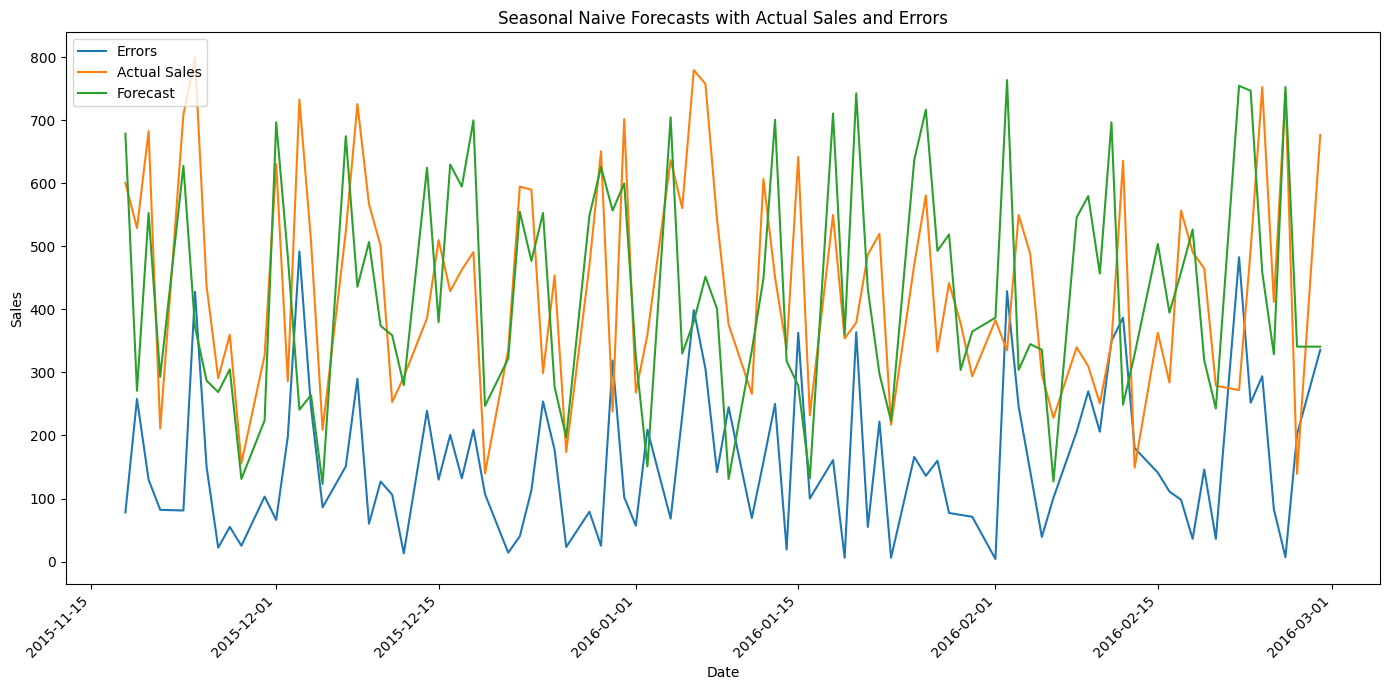

,total_sales,total_sn_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
Seasonal Naive,39335,38527.0,808.0,160.786517,199.753894,36.379814


In [161]:
# Merge test data and seasonal naive predictions
errors_df = pd.merge(test_df, sn_pred_df, on='Date')

# Select relevant columns
errors_df = errors_df[['Date', 'Count of OrderID', 'seasonal_naive_sales']]

# Calculate errors
errors_df['errors'] = errors_df['Count of OrderID'] - errors_df['seasonal_naive_sales']

# Insert model column
errors_df.insert(0, 'model', 'Seasonal Naive')

# Define functions for error metrics
def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, sales=errors_df['Count of OrderID']):
    return np.sum(np.abs(err)) / np.sum(sales) * 100

# Group errors by model and calculate metrics
result_df = errors_df.groupby('model').agg(total_sales=('Count of OrderID', 'sum'),
                                           total_sn_pred_sales=('seasonal_naive_sales', 'sum'),
                                           overall_error=('errors', 'sum'),
                                           MAE=('errors', mae), 
                                           RMSE=('errors', rmse), 
                                           MAPE=('errors', mape))

# Plot errors, actual sales, and forecast
plt.figure(figsize=(14, 7))
plt.plot(errors_df['Date'], np.abs(errors_df['errors']), label='Errors')
plt.plot(errors_df['Date'], errors_df['Count of OrderID'], label='Actual Sales')
plt.plot(errors_df['Date'], errors_df['seasonal_naive_sales'], label='Forecast')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Seasonal Naive Forecasts with Actual Sales and Errors')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

# Display error metrics
result_df


The overall error is not too bad, and we were able to achieve a <b>MAPE of 36.4%</b>. We will use this as a <b>benchmark</b> to judge the forecast performance of the linear regression model. Before proceeding with it, let's take a look at the time series decomposition plot for our training data.

### Time Series Decomposition Plot

A time series decomposition plot allows us to observe the seasonality, trend, and error/remainder terms
of a time series. These three components are a crucial part of the Exponential Smoothing models. Therfore, the decomposition plot helps in deciding the type of Exponential Smoothing Model to use for our forecasts.

In [162]:
# Set date as index and convert 'Count of OrderID' to float
ts_decomp_df = train_df.set_index('Date').astype({'Count of OrderID': float})

# Display the DataFrame
ts_decomp_df.head()

,Count of OrderID,Week Day Number,Year Quarter Number,Year,Month,Day,Quarter
Date,,,,,,,
2013-01-01,313.0,3,201301,2013,1,1,2013Q1
2013-01-02,382.0,4,201301,2013,1,2,2013Q1
2013-01-03,417.0,5,201301,2013,1,3,2013Q1
2013-01-04,239.0,6,201301,2013,1,4,2013Q1
2013-01-05,250.0,7,201301,2013,1,5,2013Q1


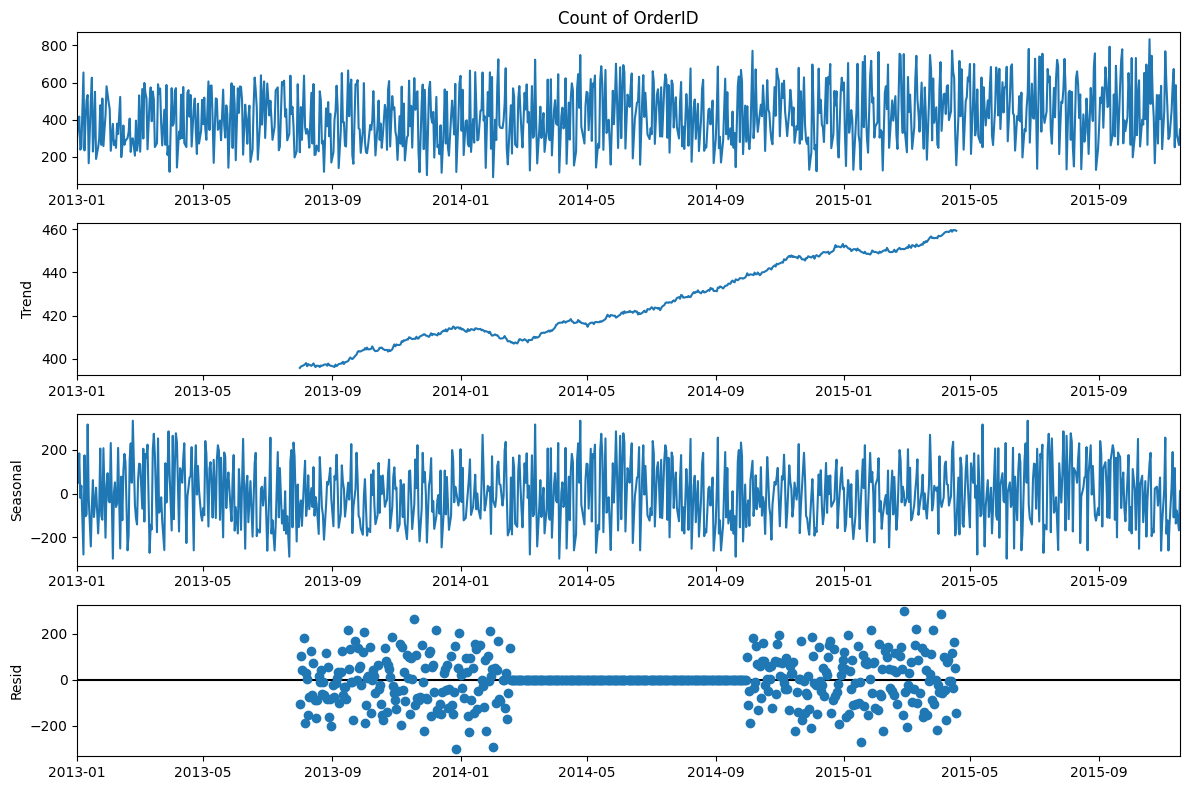

In [163]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition with the specified period
decompose_result = seasonal_decompose(ts_decomp_df['Count of OrderID'], model='additive', period=365)

# Plot the decomposition
plt.rcParams['figure.figsize'] = (12, 8)
fig = decompose_result.plot()
plt.show()

### 2. Supervised Machine Learning: Linear Regression

Let's apply Linear Regression to our time series data in order to forecasts sales.

In [358]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime, timedelta

# Load the dataset
df = pd.read_csv('data.csv')

# Feature engineering
reg_df = df.copy()

# Set Date column to datetime
reg_df['Date'] = pd.to_datetime(reg_df['Date'])

#### Step 1: Feature Engineering

In [360]:
# Define the number of lag periods
lag_periods = 7

# Adding lag columns
for i in range(1, lag_periods + 1):
    reg_df[f'lag_{i}'] = reg_df['Count of OrderID'].shift(i)

# Adding rolling mean column
reg_df['rolling_mean'] = reg_df['Count of OrderID'].rolling(window=7).mean()

# Adding rolling max column
reg_df['rolling_max'] = reg_df['Count of OrderID'].rolling(window=7).max()

# Adding rolling min column
reg_df['rolling_min'] = reg_df['Count of OrderID'].rolling(window=7).min()

# Forward-fill missing values
reg_df.fillna(method='ffill', inplace=True)

# Back-fill missing values
reg_df.fillna(method='bfill', inplace=True)



#### Step 2: Feature Selection and Model Building

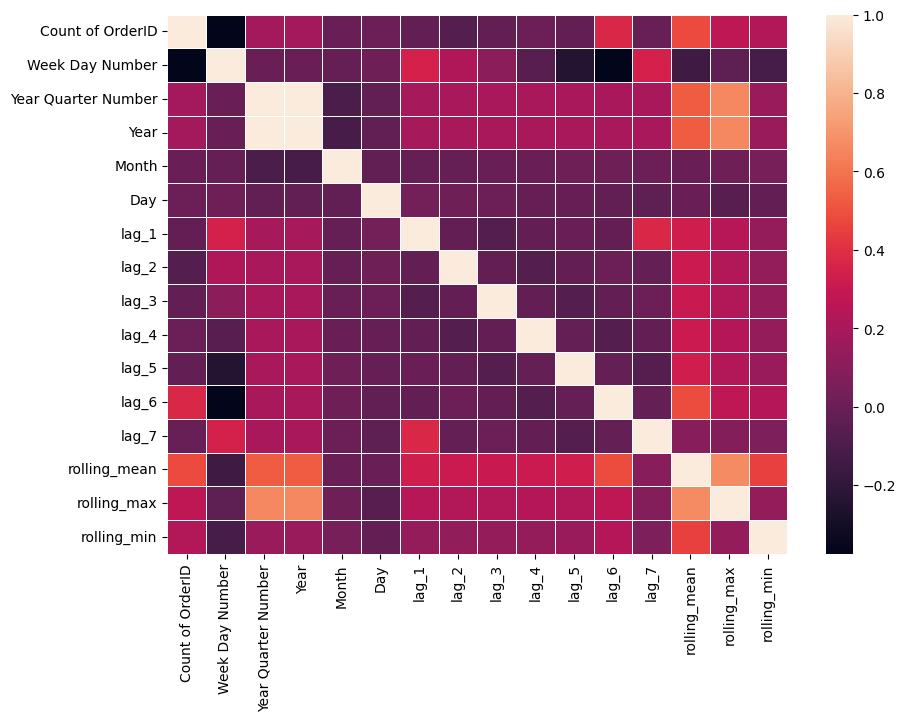

In [239]:
# Correlation matrix with heatmap
corr = reg_train_df.corr()
fig = plt.figure(figsize=(10,7))
_ = sn.heatmap(corr, linewidths=.5)

In [361]:

# Split the series for forecasting
reg_temp_df = reg_df.set_index('Date')  # Assuming 'Date' is the correct column name
reg_train_df = reg_temp_df.loc[:'2015-11-17'].reset_index(drop=False)
reg_test_df = reg_temp_df.loc['2015-11-18':].reset_index(drop=False)

# Set index to datetime and sort index
reg_train_df.set_index('Date', inplace=True)
reg_test_df.set_index('Date', inplace=True)
reg_train_df.sort_index(inplace=True)
reg_test_df.sort_index(inplace=True)

X_train = reg_train_df.drop(['Count of OrderID'], axis=1)
y_train = reg_train_df['Count of OrderID']

X_test = reg_test_df.drop(['Count of OrderID'], axis=1)
y_test = reg_test_df['Count of OrderID']

# Fit model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

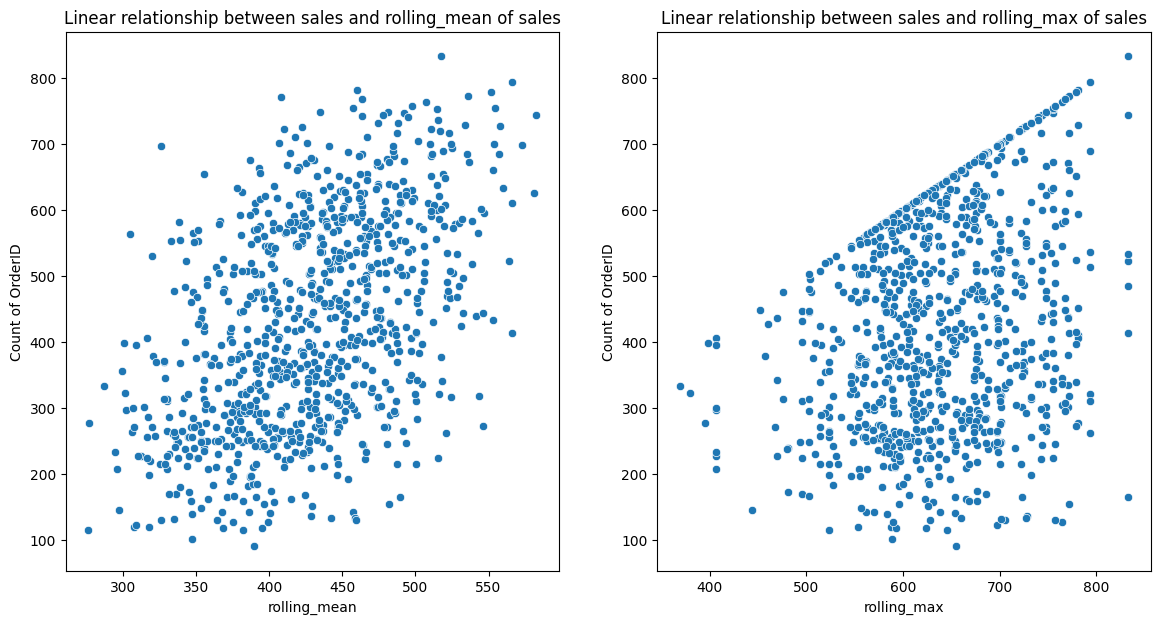

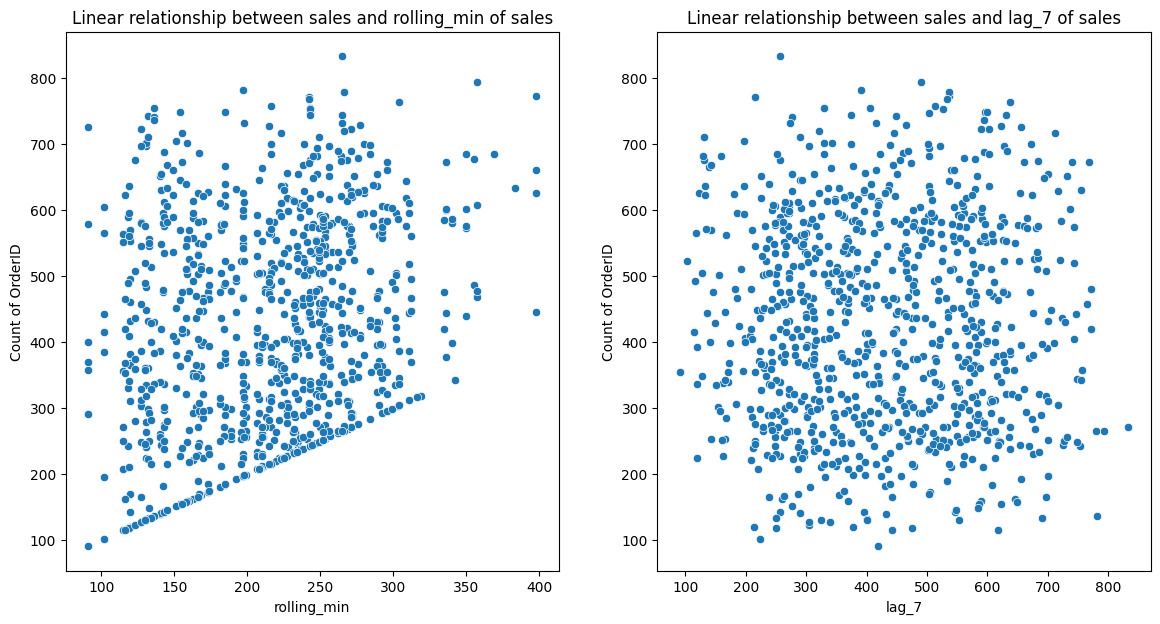

In [362]:
# Checking for a linear relationship of the top features with sales (target variable)
fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sn.scatterplot(data=reg_train_df, x='rolling_mean', y='Count of OrderID', ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_mean of sales')
sn.scatterplot(data=reg_train_df, x='rolling_max', y='Count of OrderID', ax=axs[1])
axs[1].set(title='Linear relationship between sales and rolling_max of sales')

fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sn.scatterplot(data=reg_train_df, x='rolling_min', y='Count of OrderID', ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_min of sales')
sn.scatterplot(data=reg_train_df, x='lag_7', y='Count of OrderID', ax=axs[1])
_ = axs[1].set(title='Linear relationship between sales and lag_7 of sales')


In [363]:
# Predict
preds = model.predict(X_test)

# Create errors DataFrame
errors_df = reg_test_df[['Count of OrderID']].copy()
errors_df['pred_sales'] = preds
errors_df['errors'] = preds - y_test
errors_df.insert(0, 'model', 'LinearRegression')

#### Step 3: Model Evaluation and Predictions

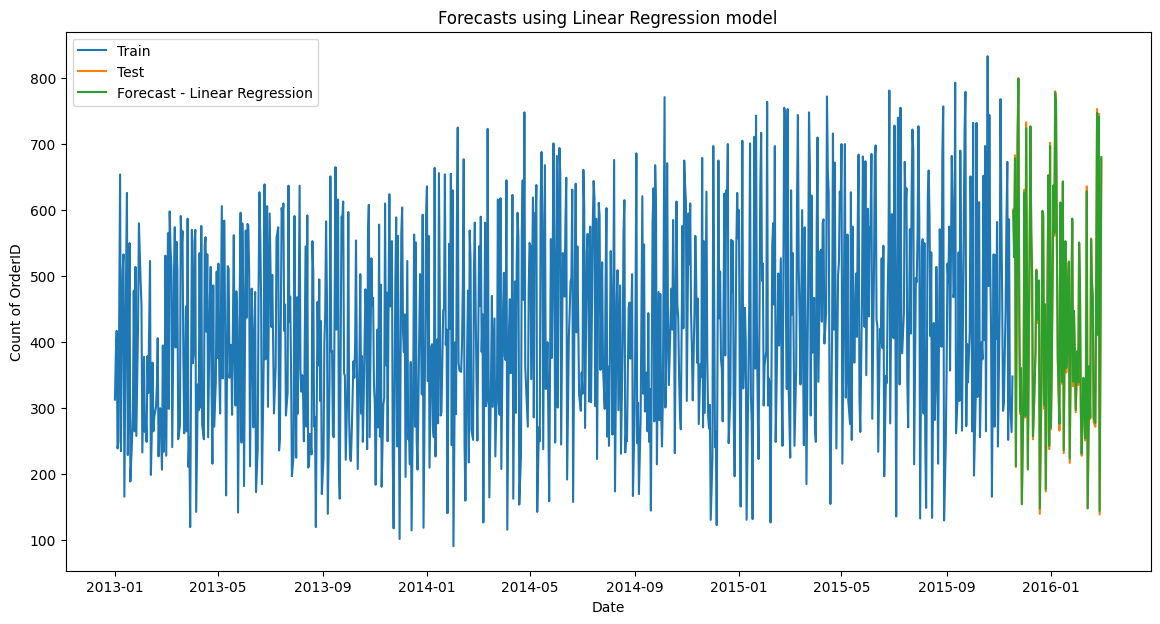

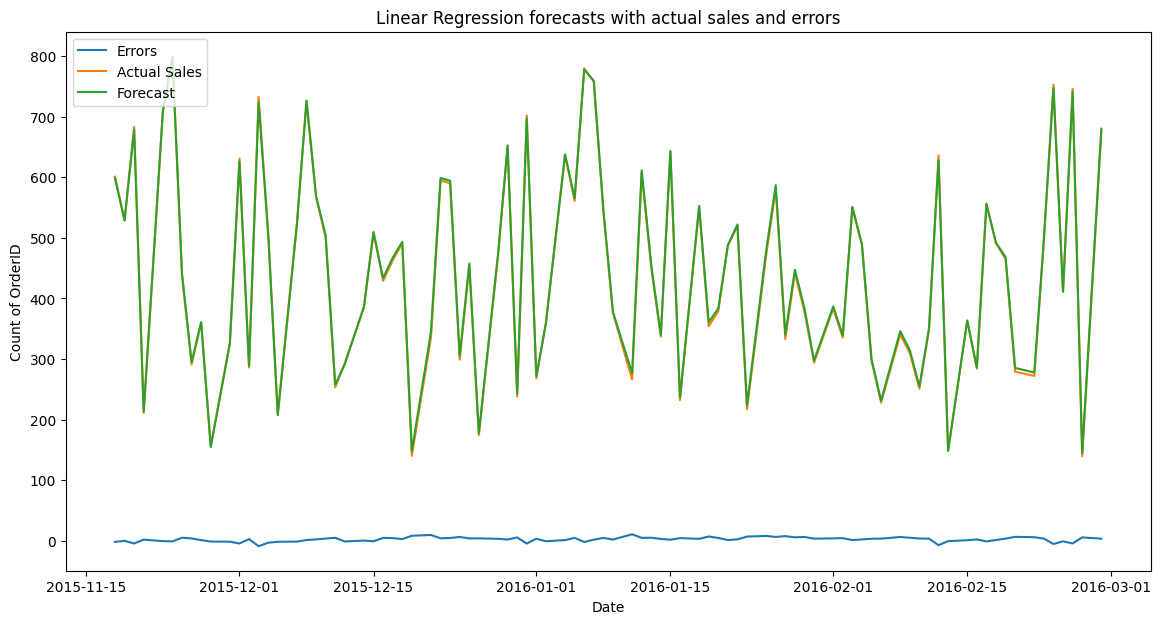

Mean Absolute Error (MAE): 3.596831384050899
Root Mean Squared Error (RMSE): 4.226248172547867
Mean Absolute Percentage Error (MAPE): 1.0175688897469557


In [364]:
# Plotting
fig = plt.figure(figsize=(14, 7))
plt.plot(reg_train_df.index, reg_train_df['Count of OrderID'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['Count of OrderID'], label='Test')
plt.plot(errors_df.index, errors_df['pred_sales'], label='Forecast - Linear Regression')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Count of OrderID')
plt.title('Forecasts using Linear Regression model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df.index, errors_df['errors'], label='Errors')
plt.plot(errors_df.index, errors_df['Count of OrderID'], label='Actual Sales')
plt.plot(errors_df.index, errors_df['pred_sales'], label='Forecast')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Count of OrderID')
plt.title('Linear Regression forecasts with actual sales and errors')
plt.show()

# Calculate MAE, RMSE, and MAPE
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
mape = np.mean(np.abs((y_test - preds) / y_test)) * 100

# Print the result metrics
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)


<b> Comments: </b> The Linear regression model captures the upwards as well as the downwards movement in the sales data. Its performance, <b> MAPE 33.8% </b>, is better than the Seasonal Naive baseline model, the value of which was 36.4%.

### 3. Forecasting 3-Months of Sales Data using Linear Regression

Let's apply Linear Regression to our time series data in order to forecasts sales 3 months from the last date in our dataset.

In [366]:
# Generate future dates for the next 90 days
future_dates = [start_date + timedelta(days=i) for i in range(90)]

# Create a DataFrame with future dates
future_df = pd.DataFrame({'Date': future_dates})

# Engineer lagged features for future dates
for i in range(1, lag_periods + 1):
    future_df[f'lag_{i}'] = future_df['Date'].apply(lambda x: reg_df['Count of OrderID'].shift(i).loc[x])

# Engineer rolling statistics for future dates
future_df['rolling_mean'] = future_df['Date'].apply(lambda x: reg_df['Count of OrderID'].loc[x - timedelta(days=6):x].mean())
future_df['rolling_max'] = future_df['Date'].apply(lambda x: reg_df['Count of OrderID'].loc[x - timedelta(days=6):x].max())
future_df['rolling_min'] = future_df['Date'].apply(lambda x: reg_df['Count of OrderID'].loc[x - timedelta(days=6):x].min())

# Predict sales for future dates
future_preds = model.predict(future_df.drop('Date', axis=1))

# Create a DataFrame for future predictions
future_predictions_df = pd.DataFrame({'Date': future_dates, 'Sales_Predicted': future_preds})

# Display the forecasted sales
print(future_predictions_df)


KeyError: Timestamp('2016-03-01 00:00:00')

### 3. Support Vector Regression

Let's apply a Support Vector Machine model to our time series data in order to forecasts sales 3 months from the last date in our dataset.

In [369]:
# Load the dataset
data = pd.read_csv('data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

data

,Count of OrderID,Week Day Number,Year Quarter Number
Date,,,
2013-01-01,313,3,201301
2013-01-02,382,4,201301
2013-01-03,417,5,201301
2013-01-04,239,6,201301
2013-01-05,250,7,201301
...,...,...,...
2016-02-24,753,4,201601
2016-02-25,412,5,201601
2016-02-26,746,6,201601


In [370]:
# Feature engineering - Transform the Date column
data['DaysSinceStart'] = (data.index - data.index.min()).days

# Prepare data for training and testing
X = data[['DaysSinceStart']]
y = data['Count of OrderID']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

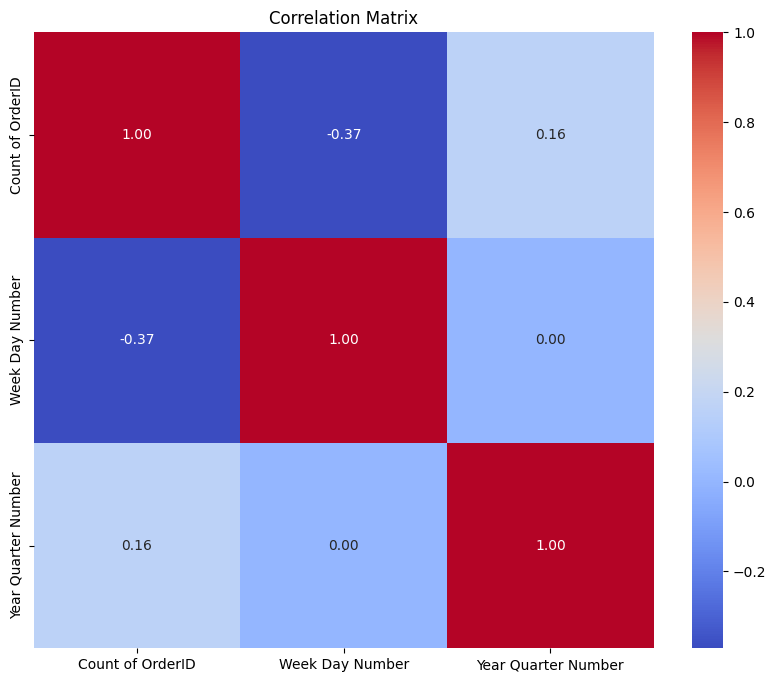

In [371]:
# Build a correlation matrix
corr_matrix = df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [372]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Set up K-Fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Tune hyperparameters using cross-validation
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': ['scale', 'auto', 0.1, 0.01, 0.001]}
grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=kfold)
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
model = SVR(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'])
model.fit(X_train_scaled, y_train)

SVR(C=100, gamma=0.01)

In [373]:
# Make predictions on the test set
predictions_train = model.predict(X_train_scaled)
predictions_test = model.predict(X_test_scaled)

# Create errors DataFrame for training
errors_train = pd.DataFrame({'Actual_Count': y_train, 'Predicted_Count': predictions_train})
errors_train['Errors'] = predictions_train - y_train
errors_train.insert(0, 'Model', 'SVR (Training Set)')

# Create errors DataFrame for testing
errors_test = pd.DataFrame({'Actual_Count': y_test, 'Predicted_Count': predictions_test})
errors_test['Errors'] = predictions_test - y_test
errors_test.insert(0, 'Model', 'SVR (Testing Set)')

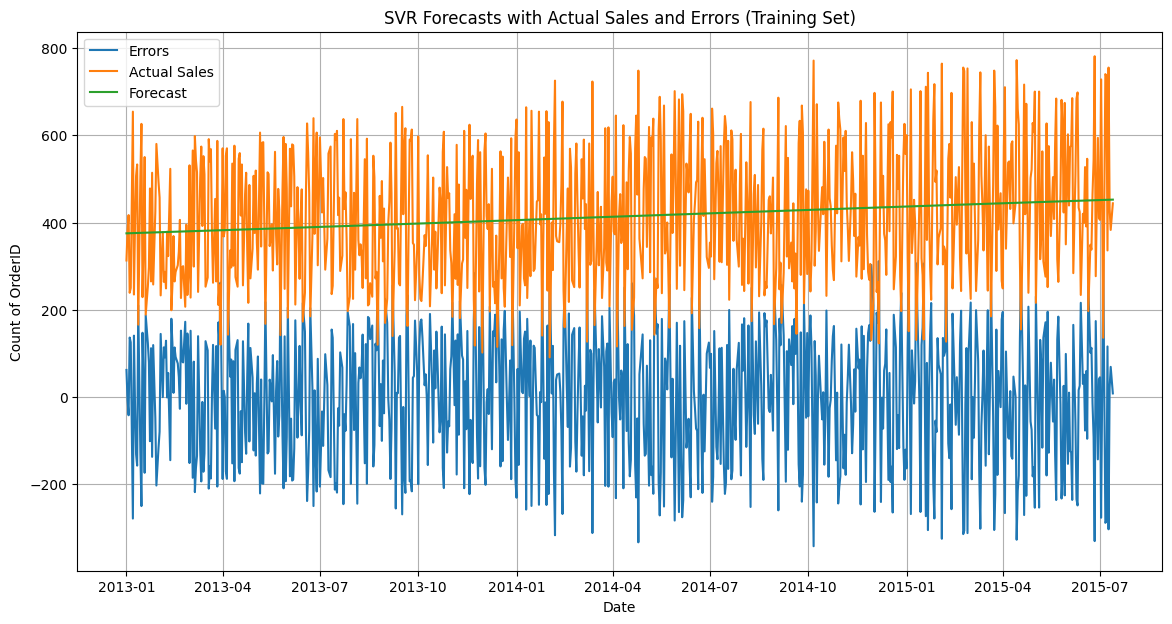

In [374]:
# Plotting errors and forecasts for training set
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(errors_train.index, errors_train['Errors'], label='Errors')
ax.plot(errors_train.index, errors_train['Actual_Count'], label='Actual Sales')
ax.plot(errors_train.index, errors_train['Predicted_Count'], label='Forecast')
ax.legend(loc='best')
ax.set_xlabel('Date')
ax.set_ylabel('Count of OrderID')
ax.set_title('SVR Forecasts with Actual Sales and Errors (Training Set)')
plt.grid(True)
plt.show()

In [375]:
# Step 10: Evaluate the model
mse_train = mean_squared_error(y_train, predictions_train)
mse_test = mean_squared_error(y_test, predictions_test)
print(f'Mean Squared Error (Training Set): {mse_train}')
print(f'Mean Squared Error (Testing Set): {mse_test}')

# Calculate MAE, RMSE, and MAPE for training set
mae_train = mean_absolute_error(y_train, predictions_train)
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_train))
mape_train = np.mean(np.abs((y_train - predictions_train) / y_train)) * 100

# Print the result metrics for training set
print("Mean Absolute Error (MAE) (Training Set):", mae_train)
print("Root Mean Squared Error (RMSE) (Training Set):", rmse_train)
print("Mean Absolute Percentage Error (MAPE) (Training Set):", mape_train)

# Calculate MAE, RMSE, and MAPE for testing set
mae_test = mean_absolute_error(y_test, predictions_test)
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_test))
mape_test = np.mean(np.abs((y_test - predictions_test) / y_test)) * 100

# Print the result metrics for testing set
print("Mean Absolute Error (MAE) (Testing Set):", mae_test)
print("Root Mean Squared Error (RMSE) (Testing Set):", rmse_test)
print("Mean Absolute Percentage Error (MAPE) (Testing Set):", mape_test)


Mean Squared Error (Training Set): 23491.316228466443
Mean Squared Error (Testing Set): 30416.51840115626
Mean Absolute Error (MAE) (Training Set): 130.70561505287867
Root Mean Squared Error (RMSE) (Training Set): 153.26877121079312
Mean Absolute Percentage Error (MAPE) (Training Set): 39.29870952626956
Mean Absolute Error (MAE) (Testing Set): 148.97370561123552
Root Mean Squared Error (RMSE) (Testing Set): 174.40332107261105
Mean Absolute Percentage Error (MAPE) (Testing Set): 43.61152623616364


### 3. Forecasting 3-Months of Sales Data using Support Vector Regression
Let's apply Support Vector Regression to our time series data in order to forecasts sales 3 months from the last date in our dataset.

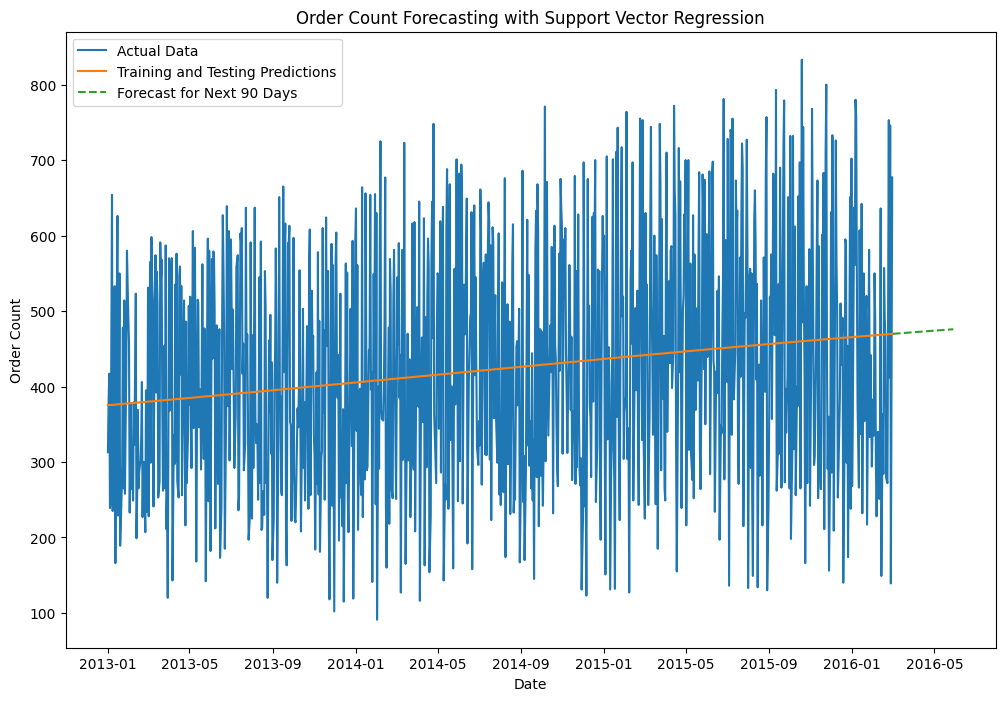

         Date  DaysSinceStart  Forecasted_Order_Count
0  2016-03-01            1155              469.790939
1  2016-03-02            1156              469.861185
2  2016-03-03            1157              469.931387
3  2016-03-04            1158              470.001545
4  2016-03-05            1159              470.071659
..        ...             ...                     ...
85 2016-05-25            1240              475.599251
86 2016-05-26            1241              475.665567
87 2016-05-27            1242              475.731835
88 2016-05-28            1243              475.798054
89 2016-05-29            1244              475.864225

[90 rows x 3 columns]


In [376]:
# Generate a forecast for the next 90 days
last_date = data.index.max()
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=90, freq='D')
days_since_start_forecast = (forecast_dates - data.index.min()).days
X_forecast_scaled = scaler.transform(days_since_start_forecast.values.reshape(-1, 1))

# Create a DataFrame for forecasting data with dates
forecast_df = pd.DataFrame({'Date': forecast_dates, 'DaysSinceStart': days_since_start_forecast})
X_forecast_scaled = scaler.transform(forecast_df[['DaysSinceStart']])

# Make predictions for the forecast data
forecast_predictions = model.predict(X_forecast_scaled)

# Display the forecast results
plt.plot(data.index, data['Count of OrderID'], label='Actual Data')
plt.plot(data.index, np.concatenate((predictions_train, predictions_test)), label='Training and Testing Predictions')
plt.plot(forecast_df['Date'], forecast_predictions, label='Forecast for Next 90 Days', linestyle='dashed')
plt.title('Order Count Forecasting with Support Vector Regression')
plt.xlabel('Date')
plt.ylabel('Order Count')
plt.legend()
plt.show()

# Print the forecast values
forecast_df['Forecasted_Order_Count'] = forecast_predictions
print(forecast_df)

# Export forecast_df to a CSV file
forecast_df.to_csv('sales_forecast.csv', index=False)


### Conclusion

We considered different regression models for time series forecasting. From our results we saw that the linear regression model outperformed the other time-series models. Therefore, for this dataset we could use a regression model, rather than a time-series model to forecast sales. One of the main assumptions of regression models is that the patterns in the historical data will be repeated in the future, and since our data was highly seasonal and had a linear trend, it made sense why the linear regression model out-performed the other models.